In [20]:
%load_ext autoreload
%autoreload 2

import astropy
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

import inspect


import apogee.tools.read as apread
import apogee.tools.path as apogee_path
from apogee.tools import bitmask
import collections

from apoNN.src.occam import Occam
from apoNN.src.datasets import ApogeeDataset,AspcapDataset
from apoNN.src.utils import get_mask_elem,dump,load
from apoNN.src.plotting import summarize_representation
import apoNN.src.vectors as vector


import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
from sklearn.decomposition import PCA,KernelPCA

from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2,interaction_only=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

apogee_path.change_dr(16)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Generating z_ae

z_ae is the raw latents for the dataset

In [2]:
elem = "Fe"
mask_elem  = get_mask_elem(elem)
autoencoder = torch.load("/share/splinter/ddm/taggingProject/apogeeFactory/outputs/guild/window/fel2/ae_20000.p",map_location=device)

/share/splinter/ddm/modules/apogee/apogee/spec/window.py:89: RuntimeWarning: invalid value encountered in greater
  mask= ((win > 0.)*(True^numpy.isnan(win))).astype('int')
/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'tagging.src.networks.Feedforward' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [3]:
allStar =  load("allStar_training_clean")
dataset=  AspcapDataset(filename="aspcap_training_clean",tensor_type=torch.FloatTensor,recenter=True)
n_data=5000

In [104]:
compressor = PCA(n_components=6,whiten=True)#z.raw.shape[1],whiten=True)


In [105]:
compressor.fit(dataset.dataset["aspcap_interpolated"])

PCA(copy=True, iterated_power='auto', n_components=6, random_state=None,
    svd_solver='auto', tol=0.0, whiten=True)

In [87]:
dataset_pred0 = compressor.inverse_transform(compressor.transform(dataset.dataset["aspcap_interpolated"]))

(0.8, 1.05)

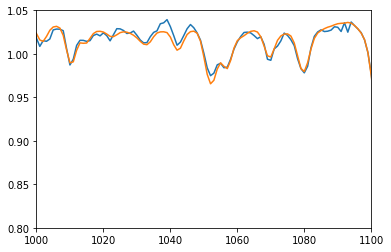

In [88]:
plt.plot(dataset.dataset["aspcap_interpolated"][0])
plt.plot(dataset_pred0[0])
plt.xlim(1000,1100)
plt.ylim(0.8,1.05)

In [89]:
loss = torch.nn.L1Loss()
pred = torch.tensor(dataset_pred0[0:10])
true = torch.tensor(dataset.dataset["aspcap_interpolated"][0:10])
loss(pred,true)

tensor(0.0046)

In [217]:
reduced_dataset = vector.Vector(dataset.dataset["aspcap_interpolated"][:5000,1000:1500]).centered

In [218]:
compressor = PCA(n_components=5,whiten=True)#z.raw.shape[1],whiten=True)


In [219]:
compressor.fit(reduced_dataset)

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
    svd_solver='auto', tol=0.0, whiten=True)

In [220]:
dataset_pred = compressor.inverse_transform(compressor.transform(reduced_dataset))

(-0.2, 0.2)

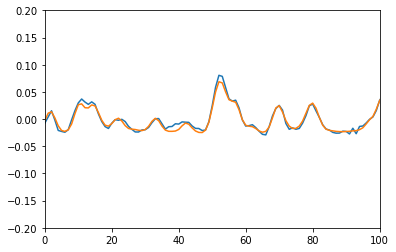

In [221]:
plt.plot(reduced_dataset[0])
plt.plot(dataset_pred[0])
plt.xlim(0,100)
plt.ylim(-0.2,0.2)

In [166]:
compressor2 = KernelPCA(n_components=10,kernel="rbf",fit_inverse_transform=True)

In [167]:
#compressor2 = PCA(n_components=10)

In [168]:
compressor2.fit(reduced_dataset)

KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
          fit_inverse_transform=True, gamma=None, kernel='rbf',
          kernel_params=None, max_iter=None, n_components=10, n_jobs=None,
          random_state=None, remove_zero_eig=False, tol=0)

In [169]:
dataset2_pred = compressor2.inverse_transform(compressor2.transform(reduced_dataset))

(-0.2, 0.2)

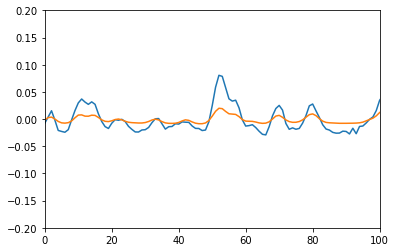

In [170]:
plt.plot(reduced_dataset[0])
plt.plot(dataset2_pred[0])
plt.xlim(0,100)
plt.ylim(-0.2,0.2)

In [195]:
from sklearn.manifold import Isomap
embedding = Isomap(n_components=10)

In [210]:
from sklearn.manifold import MDS
embedding = MDS(n_components=10,metric=False)

In [35]:
z_pca = embedding.fit_transform(reduced_dataset)

NameError: name 'embedding' is not defined

In [25]:
z_pca.shape

(5000, 30)

In [106]:
#z_pca = compressor.transform(reduced_dataset)
z_pca = compressor.transform(dataset.dataset["aspcap_interpolated"])

In [107]:
z_pca= z_pca[:n_data]


### Filtering z_ae

We want to do linear regression on the set of spectra. We must thus remove all spectra for which the enhancement estimation did not converge (these spectra then have "X_FE"=-9999)

In [158]:
feh_outliercut = allStar["Fe_H"]>-5
o_outliercut = allStar["O_FE"]>-5
c_outliercut = allStar["C_FE"]>-5
na_outliercut = allStar["Na_FE"]>-5
mg_outliercut = allStar["Mg_FE"]>-5
si_outliercut = allStar["Si_FE"]>-5
al_outliercut = allStar["Al_FE"]>-5
s_outliercut = allStar["S_FE"]>-5
p_outliercut = allStar["P_FE"]>-5
ti_outliercut = allStar["Ti_FE"]>-5
cr_outliercut = allStar["Cr_FE"]>-5
si_outliercut = allStar["Si_FE"]>-5
n_outliercut = allStar["N_FE"]>-5
ni_outliercut = allStar["Ni_FE"]>-5
mn_outliercut = allStar["Mn_FE"]>-5


combined_cut = feh_outliercut & o_outliercut &  c_outliercut & na_outliercut & mg_outliercut & si_outliercut & al_outliercut & p_outliercut & s_outliercut & ti_outliercut & cr_outliercut & si_outliercut & n_outliercut & ni_outliercut & mn_outliercut


we create a second order polynomial with the features

In [159]:
considered_parameters = ["Teff","logg","Fe_H","O_FE","C_FE","Na_FE","Mg_FE","Si_FE","S_FE","Al_FE","P_FE","Ni_FE","Mn_FE","N_FE","Cr_FE"] 
y = vector.Vector(np.array([allStar[:n_data][combined_cut[:n_data]][param] for param in considered_parameters])[:,:n_data].T)
y_astronn = vector.AstroNNVector(allStar[:n_data][combined_cut[:n_data]],considered_parameters)

In [108]:
z = vector.Vector(z_pca[combined_cut[:n_data]],order=2,interaction_only=False)

### Carrying out linear regression

We can study the linearity of our resultant representation by carrying linear and non-linear regression with the latents. We use the astroNN abundances as a gold-standard


In [109]:
w = vector.LinearTransformation(z,y)
#nonlinear_w = vector.NonLinearTransformation(z,y)
#nonlinear_w.fit(n_epochs=1000)

isomap

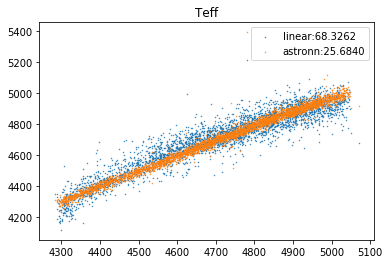

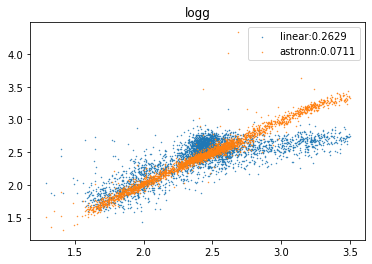

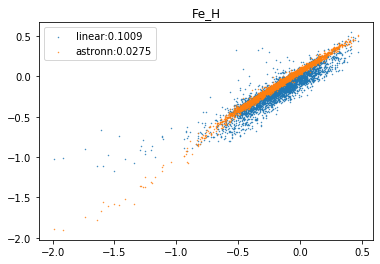

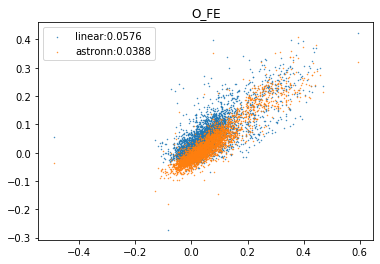

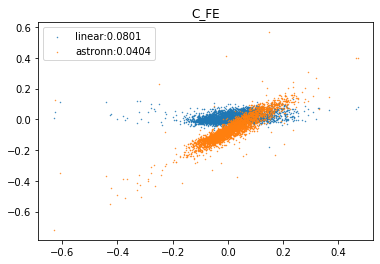

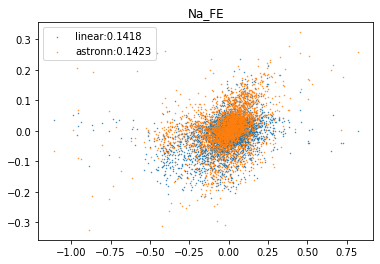

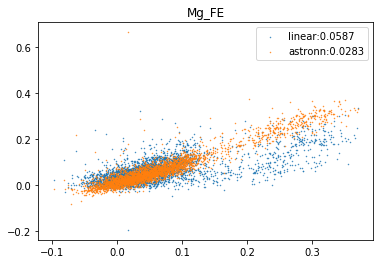

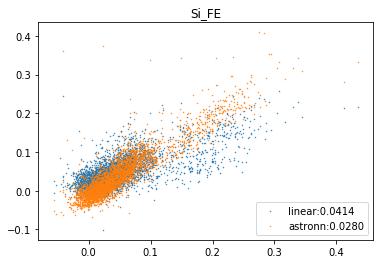

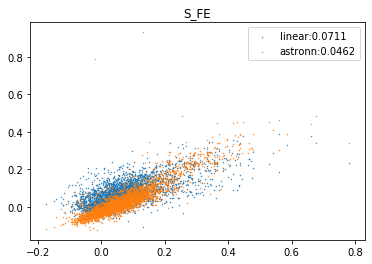

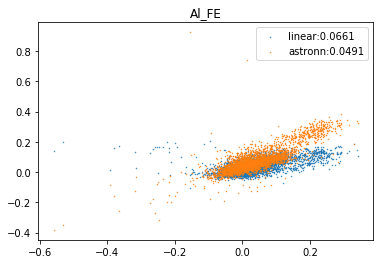

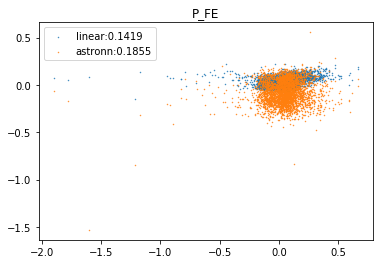

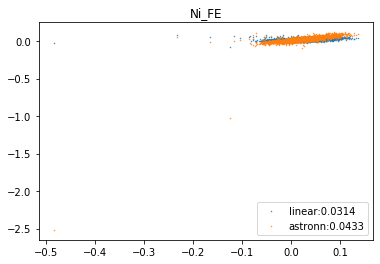

In [183]:
for i in range(len(considered_parameters)):
    plt.title(considered_parameters[i])
    #nonlinear_std = np.std(nonlinear_w.predict(z).raw[:,i]-y.raw[:,i])
    linear_std = np.std(w.predict(z).raw[:,i]-y.raw[:,i])
    astronn_std = np.std(y_astronn.raw[:,i]-y.raw[:,i])


    plt.scatter(y.raw[:,i],w.predict(z).raw[:,i],s=0.2,label="linear:{:.4f}".format(linear_std))
    #plt.scatter(y.raw[:,i],nonlinear_w.predict(z).raw[:,i],s=0.2,label="nonlinear:{:.4f}".format(nonlinear_std))
    plt.scatter(y.raw[:,i],y_astronn.raw[:,i],s=0.2,label="astronn:{:.4f}".format(astronn_std))

    plt.legend()
    plt.show()

pca

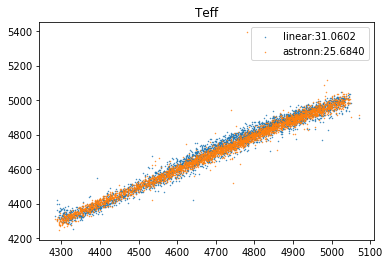

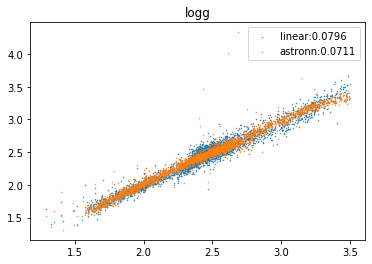

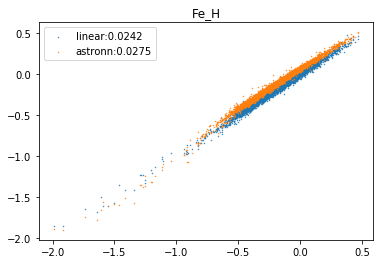

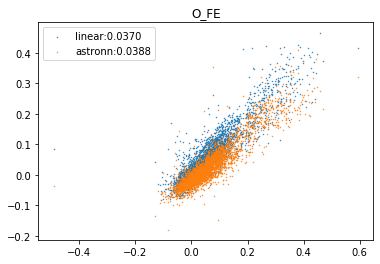

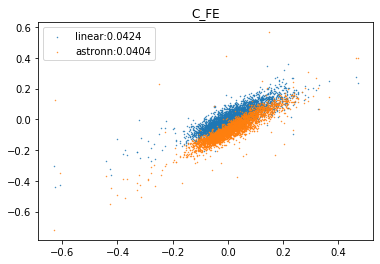

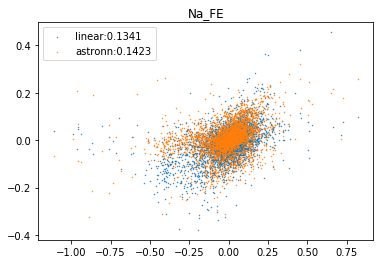

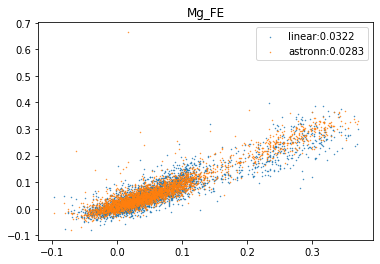

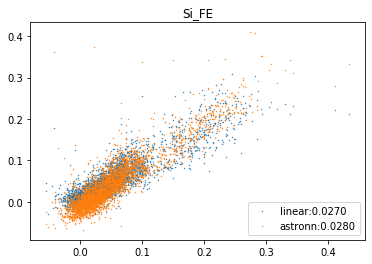

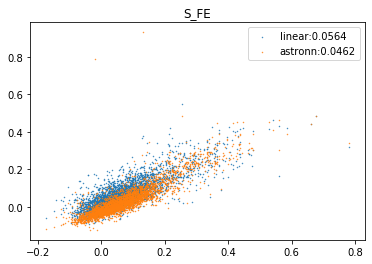

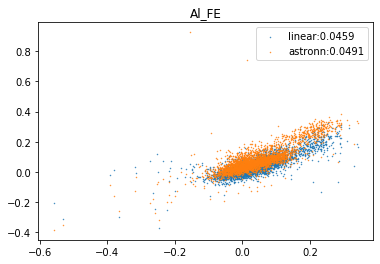

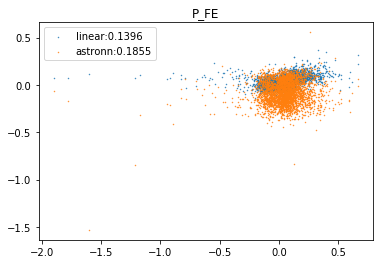

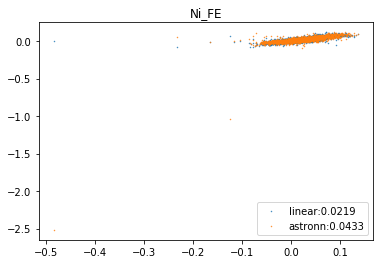

In [110]:
for i in range(len(considered_parameters)):
    plt.title(considered_parameters[i])
    #nonlinear_std = np.std(nonlinear_w.predict(z).raw[:,i]-y.raw[:,i])
    linear_std = np.std(w.predict(z).raw[:,i]-y.raw[:,i])
    astronn_std = np.std(y_astronn.raw[:,i]-y.raw[:,i])


    plt.scatter(y.raw[:,i],w.predict(z).raw[:,i],s=0.2,label="linear:{:.4f}".format(linear_std))
    #plt.scatter(y.raw[:,i],nonlinear_w.predict(z).raw[:,i],s=0.2,label="nonlinear:{:.4f}".format(nonlinear_std))
    plt.scatter(y.raw[:,i],y_astronn.raw[:,i],s=0.2,label="astronn:{:.4f}".format(astronn_std))

    plt.legend()
    plt.show()

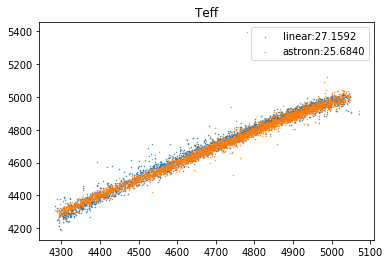

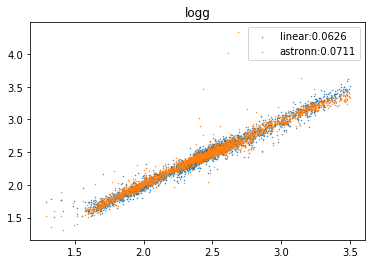

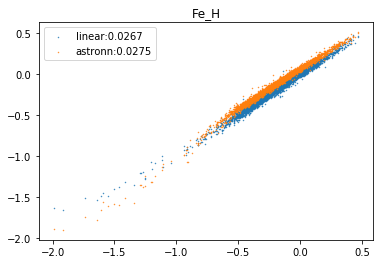

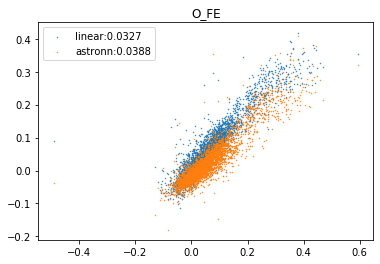

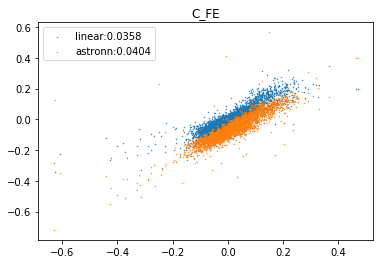

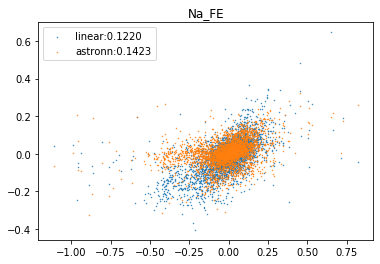

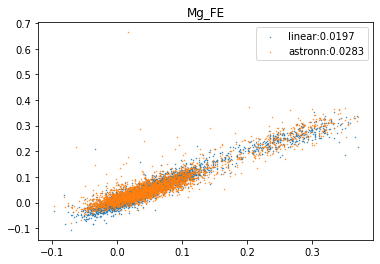

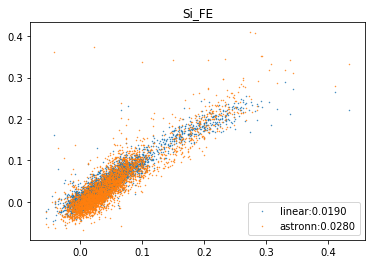

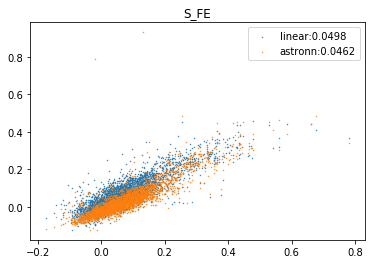

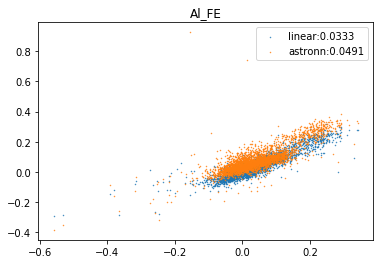

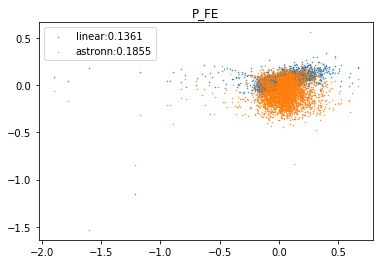

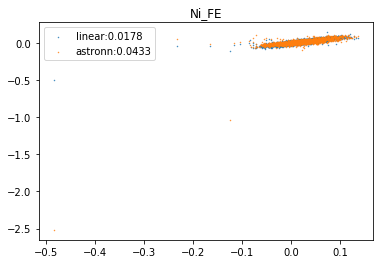

In [40]:
for i in range(len(considered_parameters)):
    plt.title(considered_parameters[i])
    #nonlinear_std = np.std(nonlinear_w.predict(z).raw[:,i]-y.raw[:,i])
    linear_std = np.std(w.predict(z).raw[:,i]-y.raw[:,i])
    astronn_std = np.std(y_astronn.raw[:,i]-y.raw[:,i])


    plt.scatter(y.raw[:,i],w.predict(z).raw[:,i],s=0.2,label="linear:{:.4f}".format(linear_std))
    #plt.scatter(y.raw[:,i],nonlinear_w.predict(z).raw[:,i],s=0.2,label="nonlinear:{:.4f}".format(nonlinear_std))
    plt.scatter(y.raw[:,i],y_astronn.raw[:,i],s=0.2,label="astronn:{:.4f}".format(astronn_std))

    plt.legend()
    plt.show()

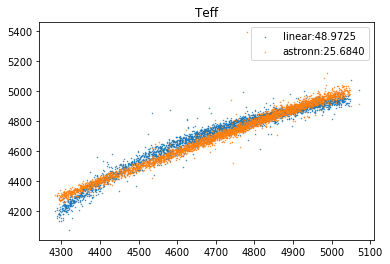

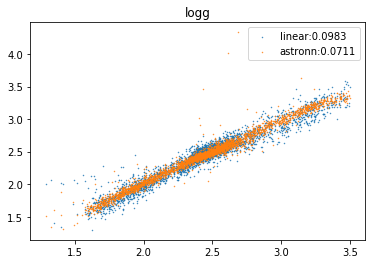

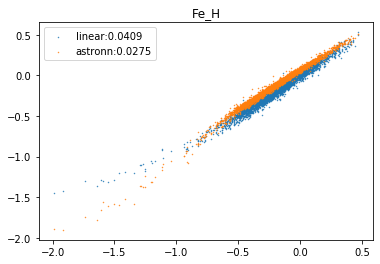

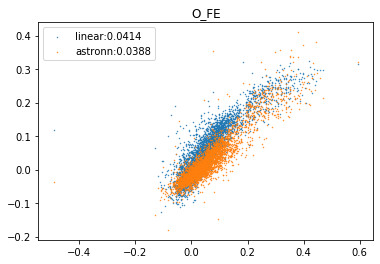

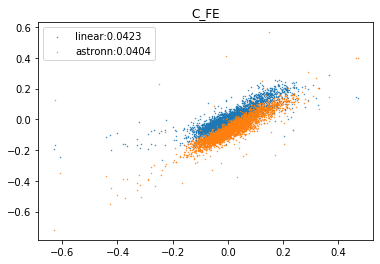

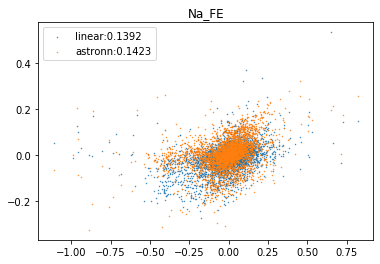

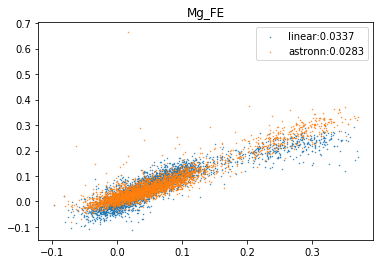

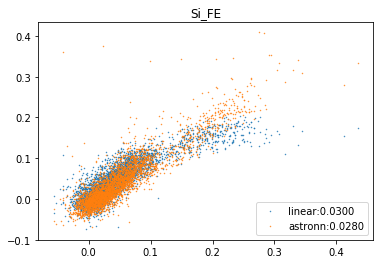

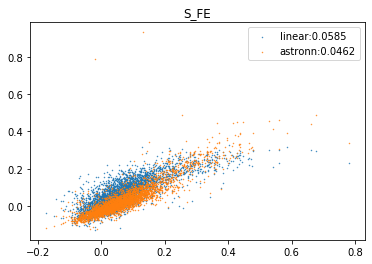

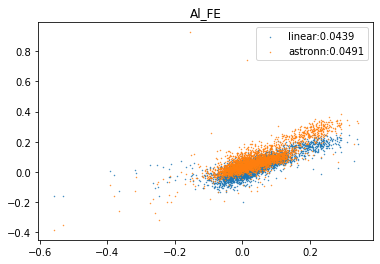

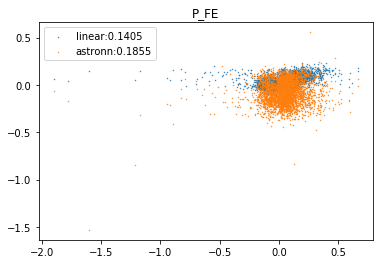

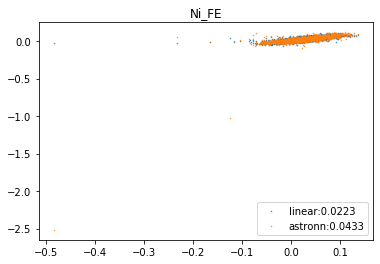

In [19]:
for i in range(len(considered_parameters)):
    plt.title(considered_parameters[i])
    #nonlinear_std = np.std(nonlinear_w.predict(z).raw[:,i]-y.raw[:,i])
    linear_std = np.std(w.predict(z).raw[:,i]-y.raw[:,i])
    astronn_std = np.std(y_astronn.raw[:,i]-y.raw[:,i])


    plt.scatter(y.raw[:,i],w.predict(z).raw[:,i],s=0.2,label="linear:{:.4f}".format(linear_std))
    #plt.scatter(y.raw[:,i],nonlinear_w.predict(z).raw[:,i],s=0.2,label="nonlinear:{:.4f}".format(nonlinear_std))
    plt.scatter(y.raw[:,i],y_astronn.raw[:,i],s=0.2,label="astronn:{:.4f}".format(astronn_std))

    plt.legend()
    plt.show()

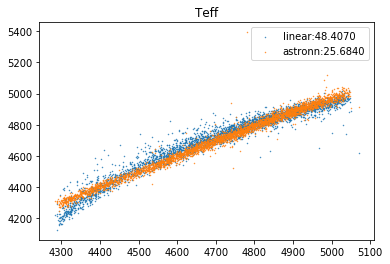

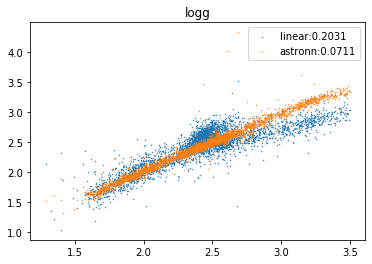

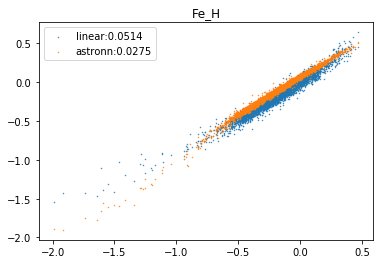

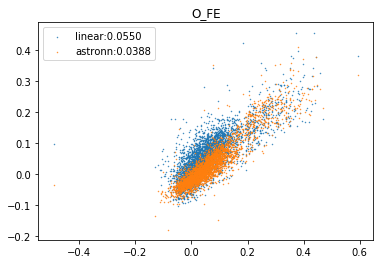

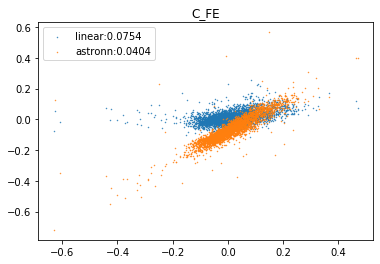

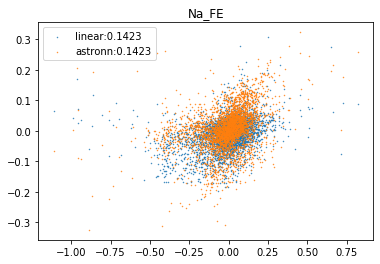

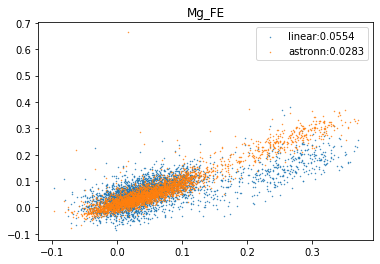

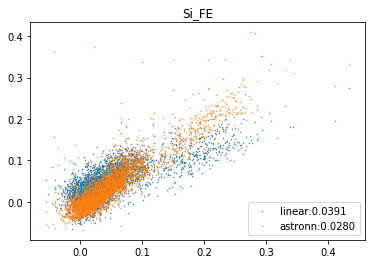

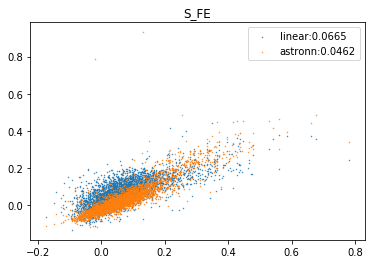

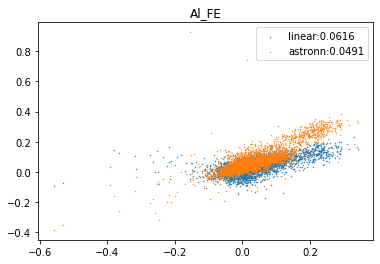

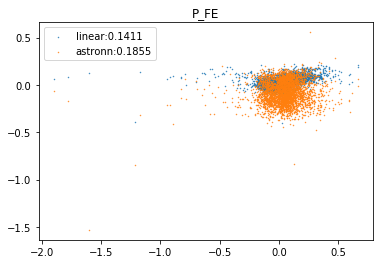

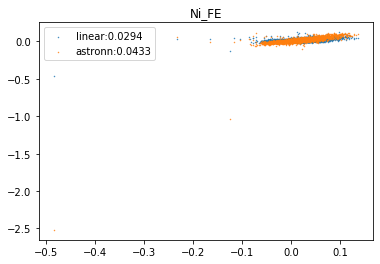

In [193]:
for i in range(len(considered_parameters)):
    plt.title(considered_parameters[i])
    #nonlinear_std = np.std(nonlinear_w.predict(z).raw[:,i]-y.raw[:,i])
    linear_std = np.std(w.predict(z).raw[:,i]-y.raw[:,i])
    astronn_std = np.std(y_astronn.raw[:,i]-y.raw[:,i])


    plt.scatter(y.raw[:,i],w.predict(z).raw[:,i],s=0.2,label="linear:{:.4f}".format(linear_std))
    #plt.scatter(y.raw[:,i],nonlinear_w.predict(z).raw[:,i],s=0.2,label="nonlinear:{:.4f}".format(nonlinear_std))
    plt.scatter(y.raw[:,i],y_astronn.raw[:,i],s=0.2,label="astronn:{:.4f}".format(astronn_std))

    plt.legend()
    plt.show()

mds

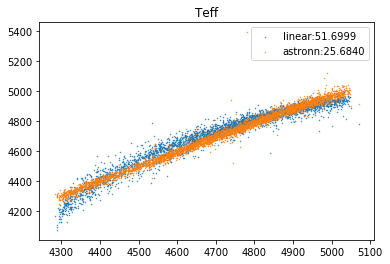

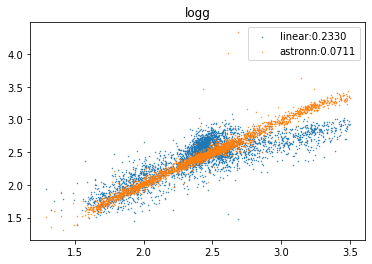

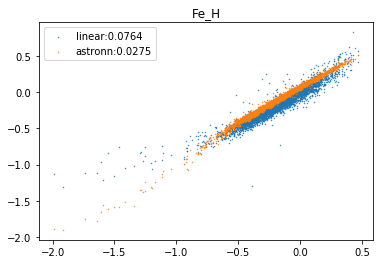

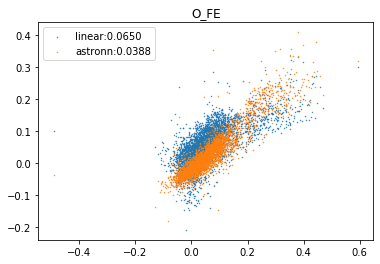

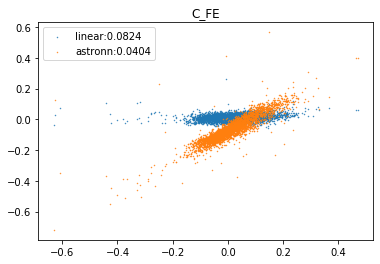

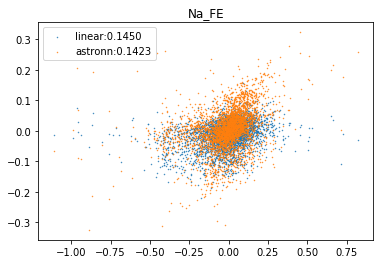

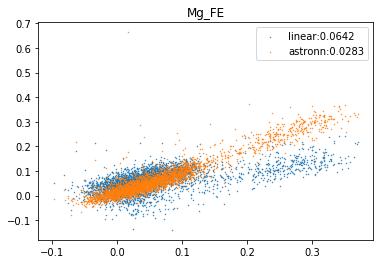

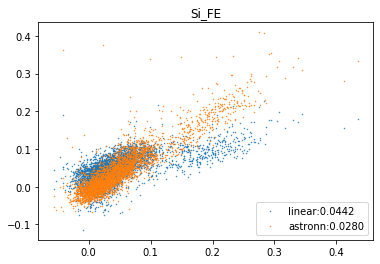

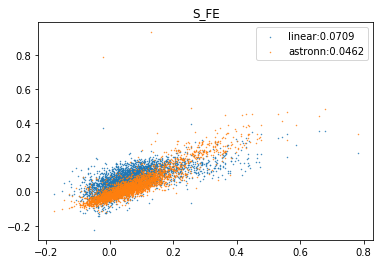

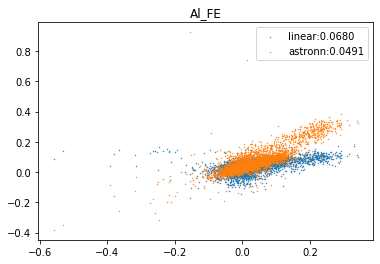

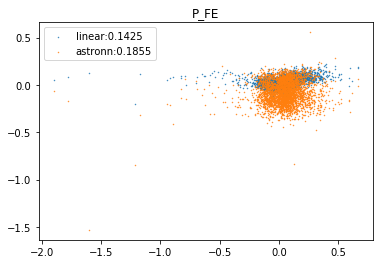

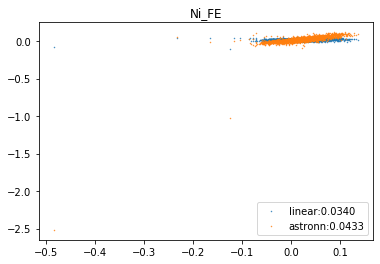

In [201]:
for i in range(len(considered_parameters)):
    plt.title(considered_parameters[i])
    #nonlinear_std = np.std(nonlinear_w.predict(z).raw[:,i]-y.raw[:,i])
    linear_std = np.std(w.predict(z).raw[:,i]-y.raw[:,i])
    astronn_std = np.std(y_astronn.raw[:,i]-y.raw[:,i])


    plt.scatter(y.raw[:,i],w.predict(z).raw[:,i],s=0.2,label="linear:{:.4f}".format(linear_std))
    #plt.scatter(y.raw[:,i],nonlinear_w.predict(z).raw[:,i],s=0.2,label="nonlinear:{:.4f}".format(nonlinear_std))
    plt.scatter(y.raw[:,i],y_astronn.raw[:,i],s=0.2,label="astronn:{:.4f}".format(astronn_std))

    plt.legend()
    plt.show()

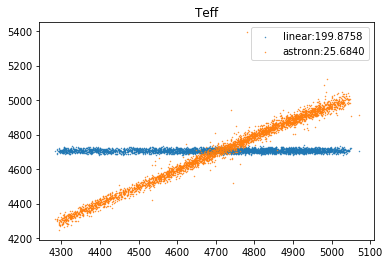

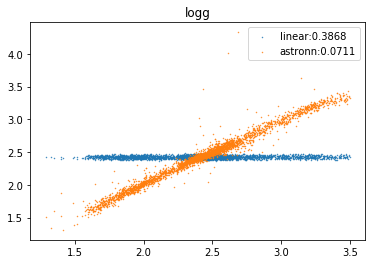

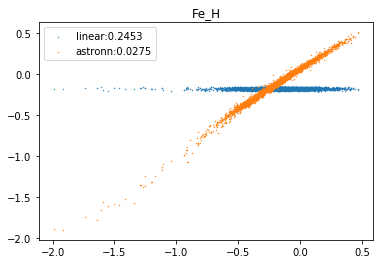

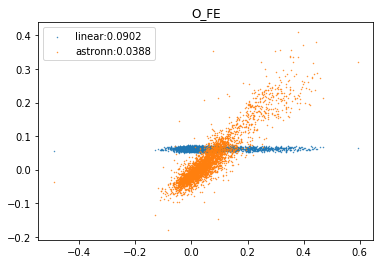

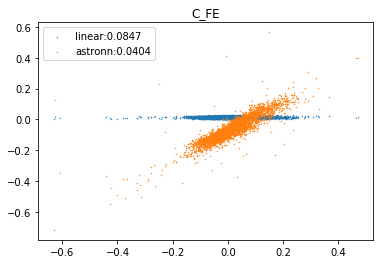

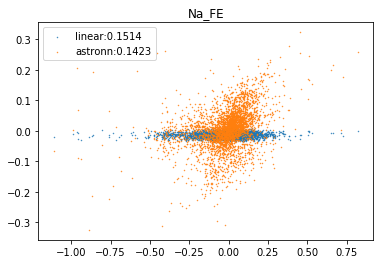

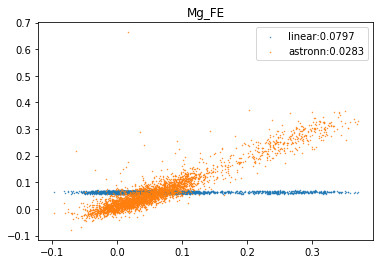

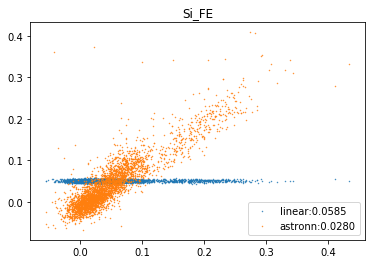

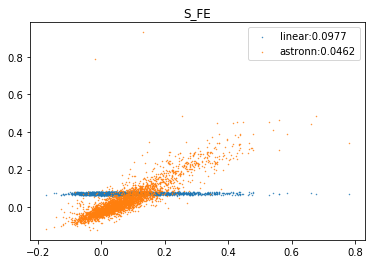

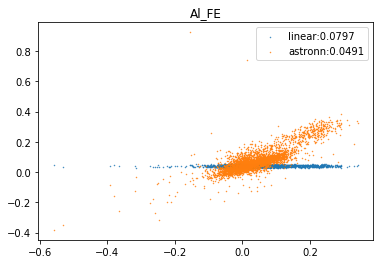

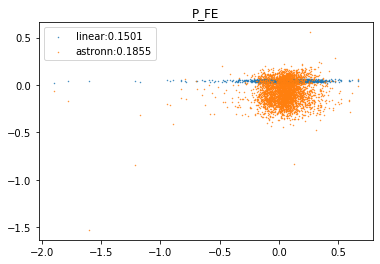

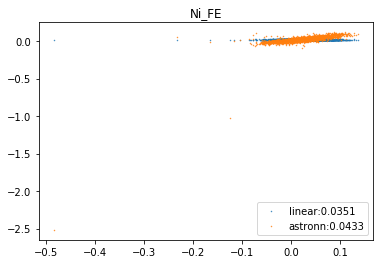

In [212]:
for i in range(len(considered_parameters)):
    plt.title(considered_parameters[i])
    #nonlinear_std = np.std(nonlinear_w.predict(z).raw[:,i]-y.raw[:,i])
    linear_std = np.std(w.predict(z).raw[:,i]-y.raw[:,i])
    astronn_std = np.std(y_astronn.raw[:,i]-y.raw[:,i])


    plt.scatter(y.raw[:,i],w.predict(z).raw[:,i],s=0.2,label="linear:{:.4f}".format(linear_std))
    #plt.scatter(y.raw[:,i],nonlinear_w.predict(z).raw[:,i],s=0.2,label="nonlinear:{:.4f}".format(nonlinear_std))
    plt.scatter(y.raw[:,i],y_astronn.raw[:,i],s=0.2,label="astronn:{:.4f}".format(astronn_std))

    plt.legend()
    plt.show()

In [ ]:
for i in range(len(considered_parameters)):
    plt.title(considered_parameters[i])
    nonlinear_std = np.std(nonlinear_w.predict(z).raw[:,i]-y.raw[:,i])
    linear_std = np.std(w.predict(z).raw[:,i]-y.raw[:,i])
    astronn_std = np.std(y_astronn.raw[:,i]-y.raw[:,i])


    plt.scatter(y.raw[:,i],w.predict(z).raw[:,i],s=0.2,label="linear:{:.4f}".format(linear_std))
    plt.scatter(y.raw[:,i],nonlinear_w.predict(z).raw[:,i],s=0.2,label="nonlinear:{:.4f}".format(nonlinear_std))
    plt.scatter(y.raw[:,i],y_astronn.raw[:,i],s=0.2,label="astronn:{:.4f}".format(astronn_std))

    plt.legend()
    plt.show()

In [ ]:
for i in range(len(considered_parameters)):
    plt.title(considered_parameters[i])
    nonlinear_std = np.std(nonlinear_w.predict(z).raw[:,i]-y.raw[:,i])
    linear_std = np.std(w.predict(z).raw[:,i]-y.raw[:,i])
    astronn_std = np.std(y_astronn.raw[:,i]-y.raw[:,i])


    plt.scatter(y.raw[:,i],w.predict(z).raw[:,i],s=0.2,label="linear:{:.4f}".format(linear_std))
    plt.scatter(y.raw[:,i],nonlinear_w.predict(z).raw[:,i],s=0.2,label="nonlinear:{:.4f}".format(nonlinear_std))
    plt.scatter(y.raw[:,i],y_astronn.raw[:,i],s=0.2,label="astronn:{:.4f}".format(astronn_std))

    plt.legend()
    plt.show()

In [ ]:
for i in range(len(considered_parameters)):
    plt.title(considered_parameters[i])
    nonlinear_std = np.std(nonlinear_w.predict(z).raw[:,i]-y.raw[:,i])
    linear_std = np.std(w.predict(z).raw[:,i]-y.raw[:,i])
    astronn_std = np.std(y_astronn.raw[:,i]-y.raw[:,i])


    plt.scatter(y.raw[:,i],w.predict(z).raw[:,i],s=0.2,label="linear:{:.4f}".format(linear_std))
    plt.scatter(y.raw[:,i],nonlinear_w.predict(z).raw[:,i],s=0.2,label="nonlinear:{:.4f}".format(nonlinear_std))
    plt.scatter(y.raw[:,i],y_astronn.raw[:,i],s=0.2,label="astronn:{:.4f}".format(astronn_std))

    plt.legend()
    plt.show()

## Occam

### Loading Occam data

In [42]:
occam = load("occam")
allStar_occam = occam["allStar"]
dataset_occam = AspcapDataset(filename="aspcap_occam",recenter=True,tensor_type=torch.FloatTensor,filling_dataset=dataset.dataset["aspcap"])

In [43]:
occam_cluster_idxs = occam["cluster_idxs"]
z_raw_occam = compressor.transform(dataset_occam.dataset["aspcap_interpolated"])
#z_occam = vector.OccamLatentVector(occam_cluster_idxs,dataset=dataset_occam,autoencoder = autoencoder,n_data = len(dataset_occam))


In [ ]:
occam_cluster_idxs

In what follows, we show a simple loop for identifying, using the reconstruction loss, any outlier spectra which are not well captured by the autoencoder

In [ ]:
bad_indexes = []
for i in range(len(z_occam.raw)):
    err = np.sqrt(np.sum(((z_occam.get_x(i)[mask_elem.astype(bool)]-z_occam.get_x_pred(i))**2).detach().numpy()))
    print(err)
    if err>0.5:
        print(err)
        print(i)
        bad_indexes.append(i)
        plt.plot(z_occam.get_x(i)[mask_elem.astype(bool)])
        plt.plot(z_occam.get_x_pred(i))
        #z_occam.plot(i)
        plt.show()

We leave a commentedout piece of code for deleting any outlier spectra, if judged necessary.

retained= np.delete(np.arange(len(z_occam.raw)),bad_indexes)
retained

In [44]:
z_occam = vector.OccamLatentVector(occam_cluster_idxs,raw=z_raw_occam,order=1,interaction_only=False)

### PCA investigation

The PCA procedure involves two steps:

1. Transform the latent representations to a whitened representation. In the whitened representation, all factors of variation in the full dataset have appropriately equal variance. 

2. Find those factors of variations, in the whitened representation, which have lowest intracluster variance. 

In [45]:
whitener = PCA(n_components=z.raw.shape[1],whiten=True)#z.raw.shape[1],whiten=True)


In [46]:
whitener.fit(z.centered)

PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
    svd_solver='auto', tol=0.0, whiten=True)

now that we have learned a whitener. We transform our dataset to the new whitened space

In [51]:
#w_z_c = whitener.transform(z.centered)
w_z_occam_c = whitener.transform(z_occam.cluster_centered)

Normally here the variance in all the directions, for the full dataset, should be roughly equal. We can check this

In [195]:
pca = PCA(n_components=z.raw.shape[1])
pca.fit(w_z_c[500:750,:])
print(pca.explained_variance_)

[3.26642    2.682928   2.3181045  2.1959195  2.0935535  1.9727665
 1.8498315  1.7406428  1.691514   1.654339   1.5489631  1.4919215
 1.4475052  1.4195257  1.3370749  1.318526   1.2491263  1.2136468
 1.1487429  1.1263039  1.0743291  1.0337157  0.9680802  0.9211293
 0.8958593  0.86556727 0.82857054]


Hopefully when we look at clusters, there should be some directions along which there are not really any variations

In [193]:
pca.fit(w_z_occam_c)
print(pca.explained_variance_)

[15.86074651 12.86346607  9.49502912  6.99248806  5.16823237  4.3507569
  3.17210078  2.78986233  2.49701574  2.11342885  2.09366125  1.87289726
  1.47336032  1.31074944  1.22072986  1.07825512  0.94283731  0.8527198
  0.80441873  0.77173634  0.69137367  0.6260433   0.5817291   0.54330398
  0.49050883  0.45065924  0.42868973]


### Assessing Open clusters

Our latent representations merit is evaluated by looking at how much variance is found within clusters compared to within full dataset. Because we don't want our representation to be influenced by outlier datapoints (where the model has failed), we threshold the most outlier datapoints.

**In this exercise, we compare Fe/H, the most well estimated parameter, to our latents smallest direction of variation**

In [127]:
dim = 50
zc_b = vector.project(w_z_c,pca.components_[dim][None,:])
zoccam_b = vector.project(w_z_occam_c,pca.components_[dim][None,:])

IndexError: index 50 is out of bounds for axis 0 with size 50

occam: 0.12201281378251304
raw: 0.3091535978340924
ratio: 2.533779758453538


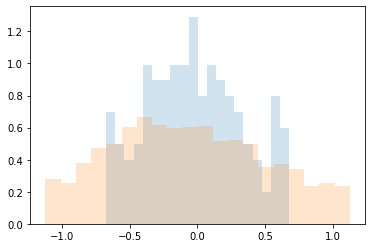

In [126]:
summarize_representation(zc_b,zoccam_b,0.2,0.2)

### Comparing to raw abundances

We can compare our representations expressiveness to the raw abundances.

In [160]:
flatten = lambda l: [item for sublist in l for item in sublist]

In [175]:
abundances_occam = []
elem = "Ni_FE"
elem_idx = considered_parameters.index(elem)

for cluster in z_occam.registry:
    clust_idxs = z_occam.registry[cluster]
    abundances_occam.append(allStar_occam[clust_idxs][elem]-np.mean(allStar_occam[clust_idxs][elem]))
    #print(z_occam.dataset.allStar[clust_idxs][elem]-z_occam.dataset.allStar[clust_idxs][elem])
abundances_occam = np.array(flatten(abundances_occam))

In [176]:
abundances_all = y.raw[:,elem_idx]-np.mean(y.raw[:,elem_idx])

occam: 0.00011830466974060982
raw: 0.0004296216939110309
ratio: 3.6314854621887207


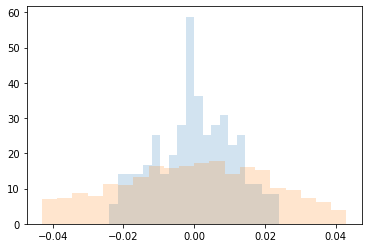

In [177]:
summarize_representation(abundances_all,abundances_occam,0.2,0.2)

In [196]:
considered_parameters

['Teff',
 'logg',
 'Fe_H',
 'O_FE',
 'C_FE',
 'Na_FE',
 'Mg_FE',
 'Si_FE',
 'S_FE',
 'Al_FE',
 'P_FE',
 'Ni_FE',
 'Mn_FE',
 'N_FE',
 'Cr_FE']

### Comparing to astroNN

In [80]:
y_astronn = vector.AstroNNVector(allStar[:n_data][combined_cut[:n_data]],considered_parameters)
y_astronn_occam = vector.AstroNNVector(allStar_occam,considered_parameters)

In [189]:
abundances_nn_occam = []
elem = "Fe_H"
elem_idx = considered_parameters.index(elem)

for cluster in z_occam.registry:
    clust_idxs = z_occam.registry[cluster]
    abundances_nn_occam.append(y_astronn_occam.raw[clust_idxs,elem_idx]-np.mean(y_astronn_occam.raw[clust_idxs,elem_idx]))
    #print(z_occam.dataset.allStar[clust_idxs][elem]-z_occam.dataset.allStar[clust_idxs][elem])
abundances_nn_occam = np.array(flatten(abundances_nn_occam))

In [190]:
abundances_nn_all  =y_astronn.raw[:,elem_idx]-np.mean(y_astronn.raw[:,elem_idx])


occam: 0.0005619442672468722
raw: 0.029721397906541824
ratio: 52.89029312133789


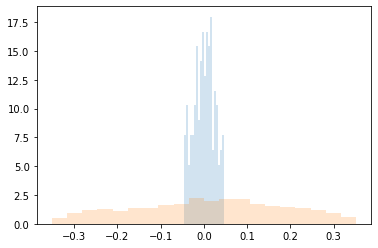

In [191]:
summarize_representation(abundances_nn_all,abundances_nn_occam,0.1,0.1)